In [1]:
import os
import numpy as np
import argparse


import pandas as pd
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time

import torch
from spiral.main import SPIRAL_integration
from spiral.layers import *
from spiral.utils import *
from spiral.CoordAlignment import CoordAlignment
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Step1:SPIRAL integration

feat:ncell * ngene matrix

edge:nedge * 2: obtained from GenerateEdges.ipynb

meta:ncell * 1或ncell * 2,containing batch information，columns is  'batch'

In [2]:
####read in orignal data ##########
dirs="/data02/tguo/space_batch_effect/Hippo/"
samples=["10X_Normal","10X_DAPI","10X_FFPE"]
SEP=','
net_cate='_KNN_'
knn=6

N_WALKS=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=knn


feat_file=[]
edge_file=[]
meta_file=[]
coord_file=[]
flags=''
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input/"+str(samples[i])+"_mat.csv")
    edge_file.append(dirs+"gtt_input/"+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
    meta_file.append(dirs+"gtt_input/"+str(samples[i])+"_meta.csv")
    coord_file.append(dirs+"gtt_input/"+str(samples[i])+"_coord.csv")
    flags=flags+'_'+samples[i]
N=pd.read_csv(feat_file[0],header=0,index_col=0).shape[1]
if (len(samples)==2):
    M=1
else:
    M=len(samples)

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=0, help='seed')
parser.add_argument('--AEdims', type=list, default=[N,[512],32], help='Dim of encoder.')
parser.add_argument('--AEdimsR', type=list, default=[32,[512],N], help='Dim of decoder.')
parser.add_argument('--GSdims', type=list, default=[512,32], help='Dim of GraphSAGE.')
parser.add_argument('--zdim', type=int, default=32, help='Dim of embedding.')
parser.add_argument('--znoise_dim', type=int, default=4, help='Dim of noise embedding.')
parser.add_argument('--CLdims', type=list, default=[4,[],M], help='Dim of classifier.')
parser.add_argument('--DIdims', type=list, default=[28,[32,16],M], help='Dim of discriminator.')
parser.add_argument('--beta', type=float, default=1.0, help='weight of GraphSAGE.')
parser.add_argument('--agg_class', type=str, default=MeanAggregator, help='Function of aggregator.')
parser.add_argument('--num_samples', type=str, default=knn, help='number of neighbors to sample.')

parser.add_argument('--N_WALKS', type=int, default=N_WALKS, help='number of walks of random work for postive pairs.')
parser.add_argument('--WALK_LEN', type=int, default=WALK_LEN, help='walk length of random work for postive pairs.')
parser.add_argument('--N_WALK_LEN', type=int, default=N_WALK_LEN, help='number of walks of random work for negative pairs.')
parser.add_argument('--NUM_NEG', type=int, default=NUM_NEG, help='number of negative pairs.')


parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=256, help='Size of batches to train.')
parser.add_argument('--lr', type=float, default=1e-3, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay.')
parser.add_argument('--alpha1', type=float, default=N, help='Weight of decoder loss.')
parser.add_argument('--alpha2', type=float, default=1, help='Weight of GraphSAGE loss.')
parser.add_argument('--alpha3', type=float, default=1, help='Weight of classifier loss.')
parser.add_argument('--alpha4', type=float, default=1, help='Weight of discriminator loss.')
parser.add_argument('--lamda', type=float, default=1, help='Weight of GRL.')
parser.add_argument('--Q', type=float, default=10, help='Weight negative loss for sage losss.')

params,unknown=parser.parse_known_args()

In [5]:
SPII=SPIRAL_integration(params,feat_file,edge_file,meta_file)
SPII.train()
if not os.path.exists(dirs+"model/"):
    os.makedirs(dirs+"model/")
torch.save(SPII.model.state_dict(),dirs+"model/SPIRAL"+flags+"_model_"+str(SPII.params.batch_size)+".pt")

In [6]:
SPII.model.eval()
all_idx=np.arange(SPII.feat.shape[0])
all_layer,all_mapping=layer_map(all_idx.tolist(),SPII.adj,len(SPII.params.GSdims))
all_rows=SPII.adj.tolil().rows[all_layer[0]]
all_feature=torch.Tensor(SPII.feat.iloc[all_layer[0],:].values).float().cuda()
all_embed,ae_out,clas_out,disc_out=SPII.model(all_feature,all_layer,all_mapping,all_rows,SPII.params.lamda,SPII.de_act,SPII.cl_act)
[ae_embed,gs_embed,embed]=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
names=['GTT_'+str(i) for i in range(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=SPII.feat.index,columns=names)
if not os.path.exists(dirs+"gtt_output/"):
    os.makedirs(dirs+"gtt_output/")
    
embed_file=dirs+"gtt_output/SPIRAL"+flags+"_embed_"+str(SPII.params.batch_size)+".csv"
embed1.to_csv(embed_file)

--------------------------------
Training.
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 1570.79509/0.36351/5.95590/1.04365/1.05966
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 795.12061/0.18308/6.06617/1.03954/0.96166
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 740.17087/0.17070/4.38431/1.02805/0.91621
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 726.61194/0.16820/1.59713/1.03202/0.89092
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 720.97816/0.16696/1.32210/1.02907/0.86451
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 712.16943/0.16494/1.22094/1.01847/0.84525
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 711.57781/0.16480/1.24550/1.01822/0.83613
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 705.90545/0.16352/1.13087/1.00885/0.79778
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 698.75440/0.16189/1.06598/0.99545/0.74117
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 703.82950/0.16307/1.05163/0.99507/0.75660
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 707.3349

total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 683.63457/0.15845/0.92270/0.61267/0.91869
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 692.79556/0.16058/0.92635/0.62108/0.93254
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 687.77651/0.15941/0.92166/0.61468/0.92564
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 687.98287/0.15946/0.91593/0.61597/0.92919
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 685.43003/0.15887/0.91361/0.61353/0.92770
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 690.51622/0.16005/0.91993/0.61713/0.93196
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 687.93181/0.15945/0.91523/0.61289/0.92792
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 687.28994/0.15930/0.91919/0.61171/0.92880
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 685.19472/0.15882/0.91085/0.60982/0.92577


Step2: clustering using seurat method in R in seurat_clustering.ipynb

In [8]:
import anndata
import scanpy as sc
adata=anndata.AnnData(SPII.feat)
adata.obsm['spiral']=embed1.iloc[:,SPII.params.znoise_dim:].values
adata.obs['batch']=SPII.meta.loc[:,'batch'].values

coord=pd.read_csv(coord_file[0],header=0,index_col=0)
for i in np.arange(1,len(samples)):
    coord=pd.concat((coord,pd.read_csv(coord_file[i],header=0,index_col=0)))
    
adata.obsm['spatial']=coord.loc[adata.obs_names,:].values
cluster_file=dirs+'metrics/spiral'+flags+'_seuratmethod_clust_modify-1.csv'
cluster=pd.read_csv(cluster_file,header=0,index_col=0)
clust=[str(x) for x in cluster.loc[adata.obs_names,:].values[:,0]]
adata.obs['SPIRAL']=clust

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SPIRAL' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical


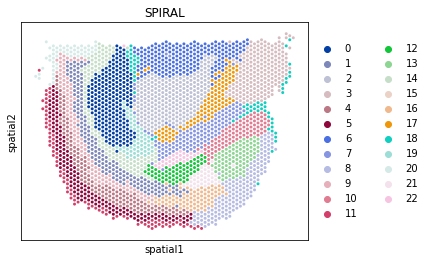

In [28]:
adata1=adata[adata.obs['batch']==ub[0],:]
sc.pl.spatial(adata1,color="SPIRAL", spot_size=100)

Step3:SPIRAL alignment

In [9]:
clust_cate="seuratmethod"
input_file=[meta_file,coord_file,embed_file,cluster_file]
output_dirs=dirs+"gtt_output/SPIRAL_alignment/"
if not os.path.exists(output_dirs):
    os.makedirs(output_dirs)
ub=['10X_Normal','10X_DAPI','10X_FFPE']

In [10]:
alpha=0.5
types="weighted_mean"
clust_cate='mclust'
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
CA=CoordAlignment(input_file=input_file,output_dirs=output_dirs,ub=ub,flags=flags,clust_cate=clust_cate,R_dirs=R_dirs,alpha=alpha,types=types)
New_Coord=CA.New_Coord
New_Coord.to_csv(output_dirs+"new_coord"+flags+"_modify.csv")

adata.obsm['aligned_spatial']=New_Coord.loc[adata.obs_names,:].values
adata.obs['celltype']=SPII.meta.loc[:,'celltype']

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

R[write to console]: Loading required package: permute

R[write to console]: Loading required package: lattice

R[write to console]: This is vegan 2.6-2



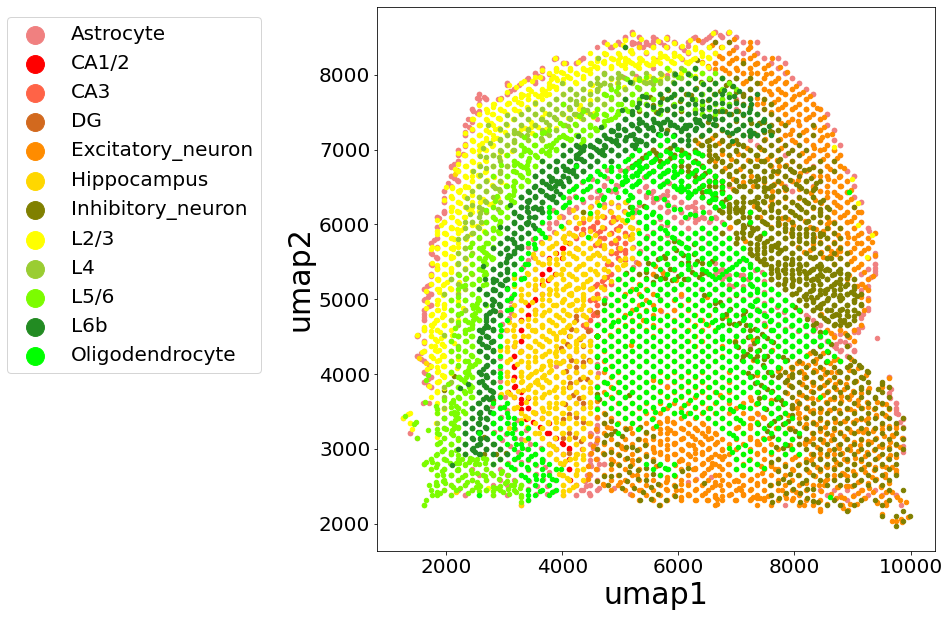

In [33]:
celltype=New_Coord.loc[:,'celltype']
ul=np.unique(celltype)
import matplotlib.pyplot as plt
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(10,10))
size=20
for i in range(len(ul)):
    axs.scatter(New_Coord.iloc[np.where(celltype==ul[i])[0],0],New_Coord.iloc[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs.set_xlabel("umap1",fontsize=30)
axs.set_ylabel("umap2",fontsize=30)
axs.legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs.tick_params(axis='both', which='major', labelsize=20)